# Contarinia nasturtii on cabbage models
We will implement atleast one model explained in the `état de l'art` of the contarinia nasturtii (cécidomyie du chou).

The model name is the "Contapré" european model. The second goal in case "Contapré" is not successful is to try to implement the model "MidgEmerge".

**Note: There is data but it needs improvements.**

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read excel or csv, sort data by date
culture = "grangeneuve" # change between "grangeneuve" and "hammerli"
df = pd.read_excel("data_{}.xls".format(culture), engine='xlrd')

df.sort_values(by=["date"], ignore_index=True, inplace=True)

plt.rcParams['figure.figsize'] = [15, 10]

# Show columns
print("Number of element (hours): ",
      df["date"].size, "\nColumns: ", df.columns)


Number of element (hours):  3439 
Columns:  Index(['date', 'air_temp_celsius_avg', 'air_temp_celsius_max',
       'air_temp_celsius_min', 'drybulb_temp_celsius_avg',
       'drybulb_temp_celsius_max', 'drybulb_temp_celsius_min',
       'dew_point_celsius_avg', 'dew_point_celsius_min', 'solar_radiation_avg',
       'vpd_kpa_avg', 'vpd_kpa_min', 'percent_humidity_avg',
       'percent_humidity_max', 'percent_humidity_min', 'precipitation_mm',
       'leaf_wetness_min', 'leaf_wetness_min2', 'leaf_wetness_min3',
       'wind_speed_ms_avg', 'wind_speed_ms_max', 'wind_speed_max_ms_max',
       'solar_panel_mv_last', 'battery_mv_last', '5te_battery_voltage_mv_last',
       'et0_mm_daily'],
      dtype='object')


## Contapré model
The accumulation of DD in the Contapré model (Bouma, 1996) begins when the daily maximum soil temperature at 5cm depth exceeds 20 °C and ≥11 mm of rain follows within 3 days (M Vlaswinkel, pers. comm.). First flight of swede midge was predicted to occur when thermal accumulations(C) exceeded that required for necessary insect development to occur, and was described by the following equation of the Contapré model:

C = $\sum_{t} (T_t - T_0)$

where t = time (days), T = mean daily temperature at soil depth of 5 cm (°C), and T0 = base threshold of development (7.2 °C). C is calculated daily and summed to the previous day’s value. When C reaches 160 DD, adult emergence should occur. Successive flights occur when C again reaches 160 DD. In addition, if the mean daily temperature over 2 days falls below 15 °C, flight is delayed until the mean daily temperature rises above this value; and, if more than 25 mm of precipitation falls between 135–160 DD, adult flight will occur immediately (M Vlaswinkel, pers. comm.). 


**Questions:**
- When do we reset the C ?
    - At the moment after 3 days of no rains.
- Do we have to reset the C after reaching 160 ?
    - No it gives more information about the gravity
    


2021-06-29
2021-07-28
2021-07-29
2021-07-30
2021-07-31
2021-08-21
2021-08-22
2021-08-23
2021-08-24


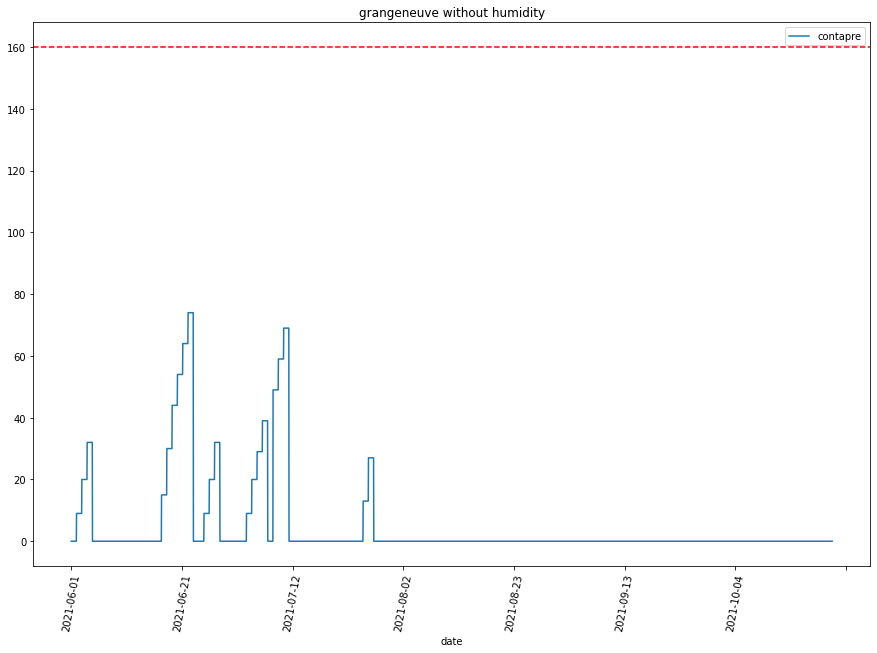

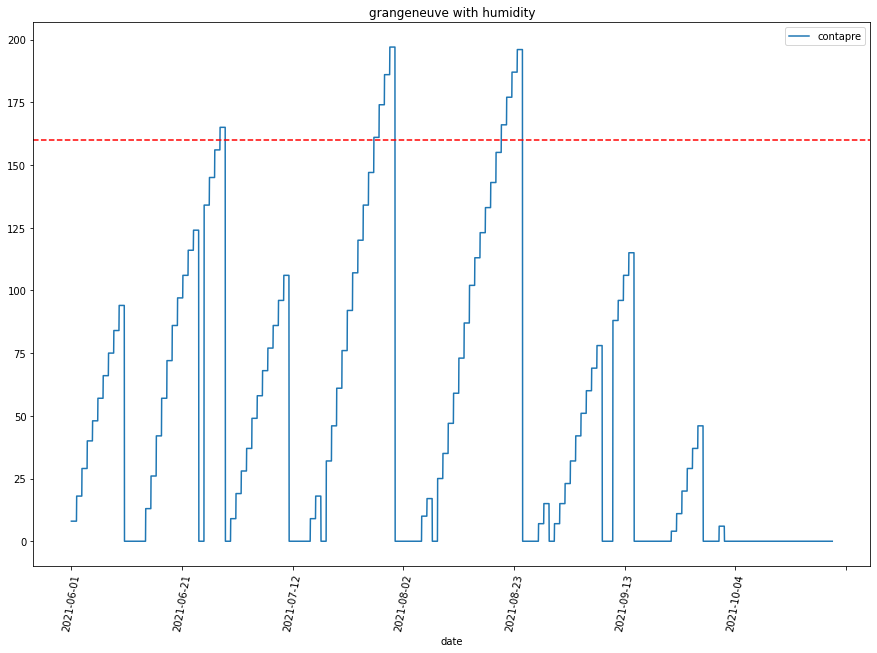

In [18]:
def check_precipitation(df, i, withHumidity):
    """
    Check that the mm of the precipitation for the next 3 days
    are atleast 11
    """
    mm = 0.0
    humidity_mean = 0.0
    j = 0
    for j in range(3 * 24):
        if i + j < len(df):
            mm += df.at[i + j, 'precipitation_mm']
            humidity_mean += df.at[i + j, 'percent_humidity_avg']
        else:
            break
    if mm >= 11 or (withHumidity and humidity_mean / (j + 1) > 75):
        return True, mm
    return False, mm


def check_temperature(df, temp_col_name, i):
    """
    Check that the temperature of the next 2 days is over 15 degrees
    """
    total_dt = 0.0
    j = 0
    for j in range(2 * 24):
        if i + j < len(df):
            total_dt += df.at[i + j, temp_col_name + "_avg"]
        else:
            break
    if total_dt / (j + 1) >= 15:
        return True

    return False


def contapre(df, withHumidity=False):
    """
    Contapré model for contarinia nasturtii.

    We tried to respect the explanation above for the 
    implementation.
    There is things we found not compatible with our
    data so we changed some parameter a bit.
    """

    df['contapre'] = 0  # add column for our results

    n = 0  # number of hours of the day
    total_dt = 0.0  # avg temp of the day
    above20 = False  # is there a temperature over 20 today
    t0 = 7.2  # base threshold of development
    c = 0
    c_not_change = 0

    for i, row in df.iterrows():
        n += 1

        # grangeneuve has no drybulb data at the beginning
        temp_col_name = 'drybulb_temp_celsius'
        if pd.isna(row['drybulb_temp_celsius_avg']):
            temp_col_name = 'air_temp_celsius'

        total_dt += row[temp_col_name + "_avg"]
        above20 = above20 or row[temp_col_name + "_max"] > 20

        # if end of the day
        if row['date'].endswith('23:00:00') or row['date'].endswith('23:00'):

            ok_humid, precipitations = check_precipitation(df, i, withHumidity)
            if above20 and ok_humid and check_temperature(df, temp_col_name, i):
                c += total_dt / n - t0

                # if between 135 et 160 and there is 25 mm of precipitations
                if c > 135 and c < 160 and precipitations > 25:
                    c = 160

                if c >= 160:
                    print(row['date'].split(' ')[0])
                    
                df.at[i, 'contapre'] = c
                df.loc[df['date'].str.startswith(
                    row['date'].split(' ')[0]),
                    ['contapre']] = df.at[i, 'contapre']  # update all rows of the day
            else:
                c_not_change += 1
                if c_not_change == 3:
                    c_not_change = 0
                    c = 0

            # prepare next day
            n = 0
            total_dt = 0
            above20 = False


contapre(df)  # call model for df

# Display results
plot = df.plot(x="date", y="contapre", rot=80, title=culture+" without humidity")
xdate = [item.get_text()[:10] for item in plot.get_xticklabels()]
_ = plot.set_xticklabels(xdate)
# there is risk of insects above the red line
_ = plt.axhline(160, color='red', linestyle='--')

contapre(df, withHumidity=True)  # call model for df

# Display results
plot = df.plot(x="date", y="contapre", rot=80, title=culture+" with humidity")
xdate = [item.get_text()[:10] for item in plot.get_xticklabels()]
_ = plot.set_xticklabels(xdate)
# there is risk of insects above the red line
_ = plt.axhline(160, color='red', linestyle='--')


# MidgEmerge

Model explained in [one of the annex of the état de l'art](https://atrium.lib.uoguelph.ca/xmlui/bitstream/handle/10214/2488/7287844341381563653.pdf;sequence=1).

Doesn't really give a lot about the model parameter, it explains how to detect each part of the insect development (egg, larva, pupal, adult) and what to look for (temperature, ...) but I think there is missing some information to be able to replicate their model.

It's still possible to give it a try, but it's probably best to first test the Contapré model with some data and to compare the model results with the observation on the field.

In [19]:
# TODO

## Save 

In [20]:
df.to_csv('res_{}.csv'.format(culture)) # need to be change if we have multiple data to process simulataneous sheets per example.